<a href="https://colab.research.google.com/github/FuadBabaev/Advanced_RL/blob/main/deep_crossentropy_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the seminar notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfon

In [2]:
# Install gymnasium if you didn't
!pip install gymnasium[toy_text,classic_control]

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


state vector dim = 4
n_actions = 2


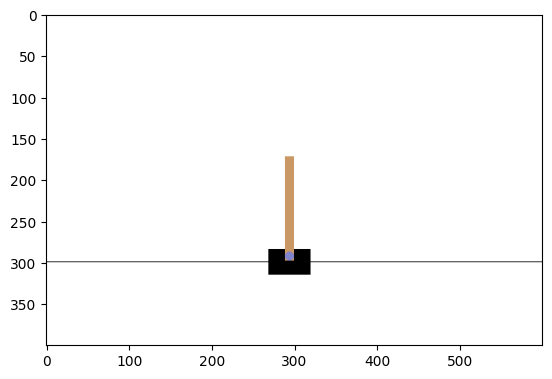

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [4]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [9]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba(np.reshape(s, (1, -1)))[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(env.action_space.n, p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward


In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[-0.02471409 -0.02174452 -0.04470647 -0.04722212]
 [-0.02514898 -0.21619785 -0.04565091  0.23102711]
 [-0.02947293 -0.41063875 -0.04103037  0.50896794]
 [-0.03768571 -0.60515934 -0.03085101  0.7884437 ]
 [-0.0497889  -0.79984426 -0.01508214  1.0712633 ]]
actions: [0, 0, 0, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [11]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)#<YOUR CODE: compute minimum reward for elite sessions. Hint: use np.percentile()>
    (elites,) = np.where(rewards_batch >= reward_threshold)

    elite_states = []#<YOUR CODE>
    elite_actions = []#<YOUR CODE>
    for i in elites:
        elite_states.extend(states_batch[i])
        elite_actions.extend(actions_batch[i])


    return elite_states, elite_actions


# Training loop
Generate sessions, select N best and fit to those.

In [13]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 989.300, threshold=1153.400


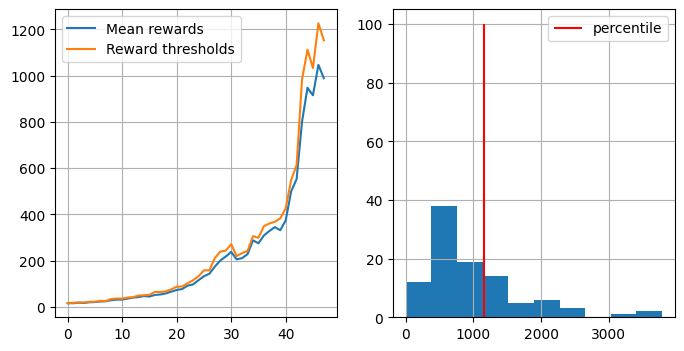

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [10]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent, t_max=10**4) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    rewards_batch = np.array(rewards_batch)


    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions, classes=np.arange(n_actions))

    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")


# Results

In [11]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [12]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (0.1 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (0.1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here>```

(314, {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})


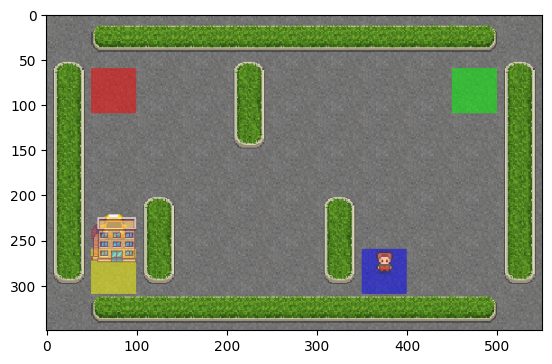

In [13]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
print(env.reset(seed=0))
plt.imshow(env.render())

In [14]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")

n_states=500, n_actions=6


In [22]:
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions

    return policy


policy = initialize_policy(n_states, n_actions)

In [17]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.0

    s, _ = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

        a = np.random.choice(n_actions, p=policy[s]) #<YOUR CODE: sample action from policy>

        new_s, r, terminated, truncated, _ = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward

In [18]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    #<YOUR CODE: set probabilities for actions given elite states & actions>
    # Don't forget to set 1/n_actions for all actions in unvisited states.
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1

    new_policy[np.where(new_policy.sum(axis=1) == 0)] = 1
    new_policy = new_policy / new_policy.sum(axis=1, keepdims=True)

    return new_policy


In [23]:
def train_taxi_cem(env, n_sessions, percentile, learning_rate, n_iterations=100):
    policy = initialize_policy(n_states, n_actions)
    log = []

    for i in range(n_iterations):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        rewards_batch = np.array(rewards_batch)

        elite_states, elite_actions = select_elites(
            states_batch, actions_batch, rewards_batch, percentile
        )
        new_policy = get_new_policy(elite_states, elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        log.append((mean_reward, threshold, rewards_batch.copy()))

    return policy, log

In [25]:
import itertools
from tqdm.notebook import tqdm

param_grid = {
    'n_sessions_list': [250, 350, 500],
    'percentile_list': [25, 50, 75],
    'learning_rate_list': [0.3, 0.5]
}

param_combinations = list(itertools.product(
    param_grid['n_sessions_list'],
    param_grid['percentile_list'],
    param_grid['learning_rate_list']
))

results = []

for (n_sessions, percentile, lr) in tqdm(param_combinations, desc="Grid Search"):
    policy, log = train_taxi_cem(env, n_sessions, percentile, lr, n_iterations=50)

    # Last iter avg reward
    final_score = log[-1]

    results.append({
        'n_sessions': n_sessions,
        'percentile': percentile,
        'learning_rate': lr,
        'final_score': final_score,
        'log': log
    })

    print(f"n_sessions={n_sessions}, percentile={percentile}, lr={lr} => final_score={final_score}")

Grid Search:   0%|          | 0/18 [00:00<?, ?it/s]

n_sessions=250, percentile=25, lr=0.3 => final_score=(-60.216, -84.75, array([ -42.,  -15.,  -56., -131.,  -78.,  -37.,  -36.,  -32.,  -95.,
        -26., -100.,  -27.,  -55.,  -54., -106.,  -17.,  -37., -121.,
        -73.,  -85.,   -7.,  -25.,  -67.,  -78.,  -71.,  -74.,  -41.,
       -107.,   -7.,  -14.,  -41.,  -70.,  -83.,  -91., -111.,  -20.,
        -72.,  -74.,  -29.,  -51.,  -39.,  -36.,  -24.,  -19.,  -80.,
         -1., -210.,  -19.,  -30.,  -60., -108.,  -43.,  -60.,  -54.,
        -75.,  -30., -164., -120.,  -43.,  -36., -110.,    1.,  -79.,
        -79.,   -7.,  -49., -104.,    3.,  -43.,  -38.,  -22.,  -64.,
        -37.,  -72.,  -30.,  -45.,  -77.,  -24.,  -43.,  -30.,  -19.,
         -7.,  -81.,  -39.,  -16.,  -18.,  -89.,  -67.,  -83., -156.,
        -78.,  -18.,  -45.,  -89.,  -53.,  -38.,  -60.,  -19.,  -16.,
        -44.,  -71.,  -85.,  -71., -122.,  -44.,  -34.,  -28.,  -61.,
        -35.,  -96., -119.,  -21.,  -29.,  -74.,  -36.,   10.,  -87.,
        -52.,  -27.

In [29]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(results)
df['final_score_clean'] = df['final_score'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
df.drop(columns=['final_score'], inplace=True)
df.rename(columns={'final_score_clean': 'final_score'}, inplace=True)

print(df.head())

   n_sessions  percentile  learning_rate  \
0         250          25            0.3   
1         250          25            0.5   
2         250          50            0.3   
3         250          50            0.5   
4         250          75            0.3   

                                                 log  final_score  
0  [(-773.704, -830.0, [-776.0, -776.0, -812.0, -...      -60.216  
1  [(-763.304, -827.75, [-812.0, -794.0, -938.0, ...       -5.740  
2  [(-772.432, -776.0, [-713.0, -221.0, -740.0, -...      -10.792  
3  [(-769.876, -780.5, [-821.0, -695.0, -794.0, -...      -30.000  
4  [(-774.748, -733.25, [-830.0, -884.0, -731.0, ...     -316.020  


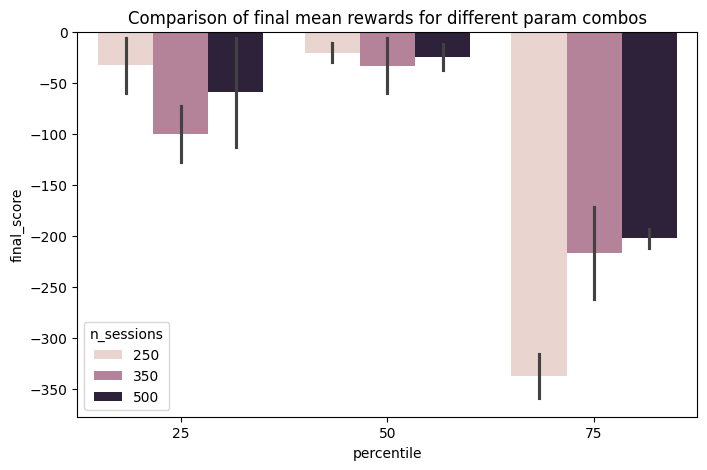

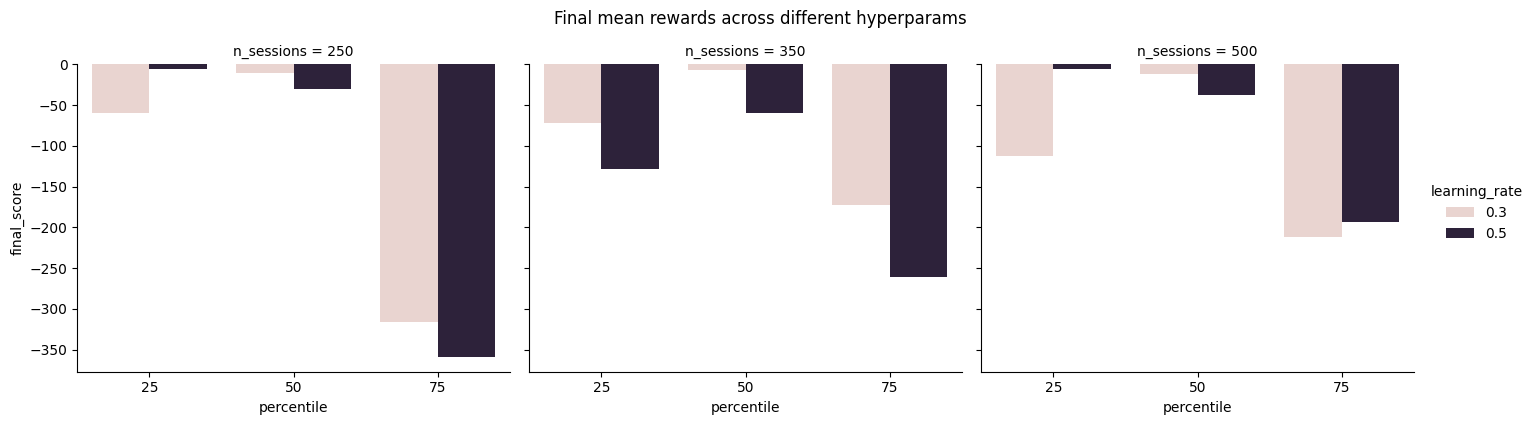

In [30]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='percentile', y='final_score', hue='n_sessions')
plt.title('Comparison of final mean rewards for different param combos')
plt.show()

g = sns.catplot(
    data=df,
    x='percentile',
    y='final_score',
    hue='learning_rate',
    col='n_sessions',
    kind='bar',
    height=4,
    aspect=1.2
)
g.fig.suptitle("Final mean rewards across different hyperparams", y=1.05)
plt.show()

- **Percentile** significantly affects the quality of selected sessions:  
  - Median value preformed the best

- **Number of sessions (n_sessions)** doesnt significantly affect the results.

- **Learning rate (learning_rate)** make a significant difference in results between for median percentile.

Based on factors above let's try to keep 600 sessions, 50-percentile and try to lower **lr** to 0.2.

In [51]:
policy = initialize_policy(n_states, n_actions)

mean reward = 0.267, threshold=5.000


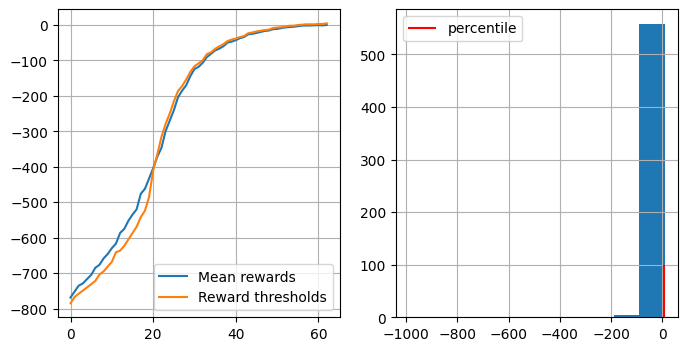

In [52]:
n_sessions = 600
percentile = 50
learning_rate = 0.2

log = []

for i in range(100):
    %time sessions = [ generate_session(env, policy, t_max=10**4) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    show_progress(rewards_batch, log, percentile)

    if np.mean(rewards_batch) > 0:
      break

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (0.3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 0.5 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (0.1 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (0.2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (0.2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [5]:
! pip install swig

  Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)


In [6]:
! pip install gymnasium[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379449 sha256=a71fdacd14674dfb2cad3b8e6374c25bbd5b81ecdd0fd9efa82a17a08eb91734
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

%matplotlib inline

env = gym.make("LunarLander-v3")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

In [8]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(200, 200, 200),
    activation="relu",
)

agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(hidden_layer_sizes=(200, 200, 200))

mean reward = 51.756, threshold=53.887


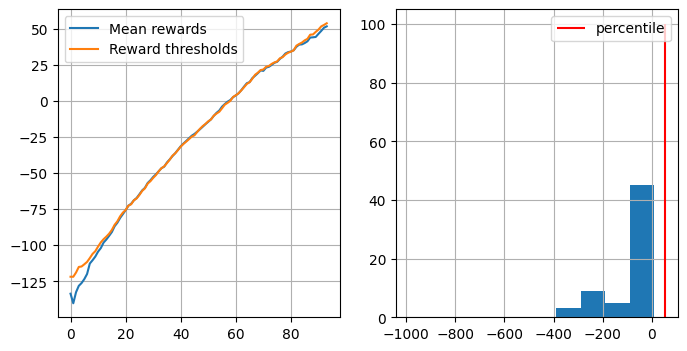

KeyboardInterrupt: 

In [14]:
n_sessions = 200
percentile = 50
log = []

sessions_prev = []

for i in range(200):
    # Generate new sessions (in parallel)
    sessions = Parallel(n_jobs=20)(delayed(generate_session)(env, agent) for _ in range(n_sessions))
    sessions_all = []
    sessions_all.extend(sessions)

    # Extend with sessions from previous iterations stored in sessions_prev
    for past_sessions in sessions_prev:
        sessions_all.extend(past_sessions)

    states_batch = []
    actions_batch = []
    rewards_batch = []
    for session in sessions_all:
        states, actions, reward = session
        states_batch.append(states)
        actions_batch.append(actions)
        rewards_batch.append(reward)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    agent.partial_fit(elite_states, elite_actions, classes=np.arange(n_actions))

    show_progress(rewards_batch, log, percentile)
    sessions_prev.append(sessions)

    # Keep only the last 5 iters
    if len(sessions_prev) > 5:
        sessions_prev = sessions_prev[-5:]

### Bonus tasks

* __2.3 bonus__ (0.2 pts) Try to find a network architecture and training params that solve __both__ environments above.

* __2.4 bonus__ (0.3 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 0.3 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.